In [1]:
import scipy.io as spio
import numpy as np

In [2]:
X = spio.loadmat(file_name='../data/bci-sample-data/x.mat')

In [3]:
Y = spio.loadmat(file_name='../data/bci-sample-data/y.mat')

In [4]:
Data = X['Intensification_Data']
SType = Y['Intensification_SType'].mean(axis=1)

In [5]:
# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [6]:
# Standardize/normalize train and test
X_norm = normalize(inputs=Data)

In [7]:
# Deviding the input data into train and validation
# 30 % of data is test and the rest train
length = int(X_norm.shape[0] * 0.3)
X_train_norm = X_norm[: -length]
X_valid_norm = X_norm[-length:]

In [8]:
Y_train = np.array(SType[ :-length], dtype=int)
Y_valid = np.array(SType[-length: ], dtype=int)

In [9]:
(X_train_norm.shape, X_train_norm.dtype, Y_train.shape, Y_train.dtype)

((4536, 192, 64), dtype('<f8'), (4536,), dtype('int64'))

### Hyperparameters

In [51]:
# Input data
# X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 100 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
# Y_(5832, 2): (n_trails, n_classes)
n_classes = Y_train.max() + 1

# Tweekable parameters
learning_rate = 0.0001 #1e-4
epochs = 10 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [52]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)

In [53]:
(Y_train_onehot.shape, Y_valid_onehot.shape, X_train_norm.shape, X_valid_norm.shape)

((4536, 2), (1944, 2), (4536, 192, 64), (1944, 192, 64))

# GPUs availability or CPU

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [55]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers, FC Layer, and Output layer

In [56]:
# (batch, 192, 9) --> (batch, 91, 18)
out_conv = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=12, strides=2, 
                         padding='valid', activation = tf.nn.relu)
print(out_conv.shape)

# (batch, 91, 18) --> (batch, 91*18) --> (batch, 91*18*2) 
in_fc = tf.reshape(out_conv, (-1, 91*18))
out_fc = tf.layers.dense(inputs=in_fc, units=91*18*2, activation=tf.nn.relu)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 91*18*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 91, 18)
(?, 1638) (?, 3276)
(?, 2)


In [57]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [58]:
train_losses, valid_losses = [], []
train_acc_list, valid_acc_list = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over training minibatches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary of training minibatch
            feed = {inputs_:x, labels_:y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            # Feed dictionary of validation full-batch 
            # no dropout/keep_prob; no learning rate/ no learning
            feed = {inputs_:X_valid_norm, labels_:Y_valid_onehot, keep_prob_:1.0}
            valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed)

            # Print at each iter/ epoch
            print("Epoch: {}/{}".format(e, epochs),
                  "Train loss: {:6f}".format(train_loss),
                  "Valid loss: {:.6f}".format(valid_loss),
                  "train acc: {:.6f}".format(train_acc),
                  "Valid acc: {:.6f}".format(valid_acc))

            # Ploting the learning curve for training and validation
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

Epoch: 0/10 Train loss: 0.669358 Valid loss: 0.671576 train acc: 0.822222 Valid acc: 0.592593
Epoch: 0/10 Train loss: 1.271203 Valid loss: 0.557615 train acc: 0.311111 Valid acc: 0.830247
Epoch: 0/10 Train loss: 0.684905 Valid loss: 0.663132 train acc: 0.800000 Valid acc: 0.833333
Epoch: 0/10 Train loss: 0.556026 Valid loss: 0.801990 train acc: 0.822222 Valid acc: 0.833333
Epoch: 0/10 Train loss: 0.827968 Valid loss: 0.866448 train acc: 0.844445 Valid acc: 0.833333
Epoch: 0/10 Train loss: 0.609183 Valid loss: 0.894991 train acc: 0.844445 Valid acc: 0.833333
Epoch: 0/10 Train loss: 1.538550 Valid loss: 0.820736 train acc: 0.800000 Valid acc: 0.833333
Epoch: 0/10 Train loss: 0.472113 Valid loss: 0.757054 train acc: 0.844445 Valid acc: 0.833333
Epoch: 0/10 Train loss: 0.518628 Valid loss: 0.688496 train acc: 0.822222 Valid acc: 0.833333
Epoch: 0/10 Train loss: 0.770761 Valid loss: 0.631839 train acc: 0.822222 Valid acc: 0.824074
Epoch: 0/10 Train loss: 0.530188 Valid loss: 0.621635 train 

Epoch: 0/10 Train loss: 0.499974 Valid loss: 0.432992 train acc: 0.822222 Valid acc: 0.832819
Epoch: 0/10 Train loss: 0.453098 Valid loss: 0.433250 train acc: 0.844445 Valid acc: 0.832819
Epoch: 0/10 Train loss: 0.363420 Valid loss: 0.432954 train acc: 0.866667 Valid acc: 0.832819
Epoch: 0/10 Train loss: 0.428179 Valid loss: 0.432696 train acc: 0.800000 Valid acc: 0.832819
Epoch: 0/10 Train loss: 0.562452 Valid loss: 0.431888 train acc: 0.844445 Valid acc: 0.832304
Epoch: 0/10 Train loss: 0.490253 Valid loss: 0.432123 train acc: 0.822222 Valid acc: 0.832304
Epoch: 0/10 Train loss: 0.493812 Valid loss: 0.432744 train acc: 0.822222 Valid acc: 0.832819
Epoch: 0/10 Train loss: 0.504112 Valid loss: 0.435273 train acc: 0.822222 Valid acc: 0.832304
Epoch: 0/10 Train loss: 0.457694 Valid loss: 0.437611 train acc: 0.822222 Valid acc: 0.832304
Epoch: 0/10 Train loss: 0.429618 Valid loss: 0.439347 train acc: 0.822222 Valid acc: 0.832304
Epoch: 0/10 Train loss: 0.400394 Valid loss: 0.437925 train 

Epoch: 1/10 Train loss: 0.280497 Valid loss: 0.397730 train acc: 0.888889 Valid acc: 0.840535
Epoch: 1/10 Train loss: 0.290705 Valid loss: 0.397720 train acc: 0.866667 Valid acc: 0.841049
Epoch: 1/10 Train loss: 0.406805 Valid loss: 0.398569 train acc: 0.800000 Valid acc: 0.843621
Epoch: 1/10 Train loss: 0.366691 Valid loss: 0.399791 train acc: 0.822222 Valid acc: 0.844650
Epoch: 1/10 Train loss: 0.386419 Valid loss: 0.400932 train acc: 0.844445 Valid acc: 0.845164
Epoch: 1/10 Train loss: 0.353497 Valid loss: 0.400857 train acc: 0.888889 Valid acc: 0.846193
Epoch: 1/10 Train loss: 0.338285 Valid loss: 0.398893 train acc: 0.888889 Valid acc: 0.846193
Epoch: 1/10 Train loss: 0.399881 Valid loss: 0.396697 train acc: 0.911111 Valid acc: 0.843621
Epoch: 1/10 Train loss: 0.387317 Valid loss: 0.395276 train acc: 0.844445 Valid acc: 0.842078
Epoch: 1/10 Train loss: 0.311891 Valid loss: 0.394984 train acc: 0.844445 Valid acc: 0.840020
Epoch: 1/10 Train loss: 0.475325 Valid loss: 0.395645 train 

Epoch: 2/10 Train loss: 0.316396 Valid loss: 0.410398 train acc: 0.888889 Valid acc: 0.828704
Epoch: 2/10 Train loss: 0.400145 Valid loss: 0.406363 train acc: 0.777778 Valid acc: 0.833848
Epoch: 2/10 Train loss: 0.336855 Valid loss: 0.400140 train acc: 0.822222 Valid acc: 0.838992
Epoch: 2/10 Train loss: 0.250854 Valid loss: 0.394214 train acc: 0.955556 Valid acc: 0.843107
Epoch: 2/10 Train loss: 0.621754 Valid loss: 0.388840 train acc: 0.711111 Valid acc: 0.845679
Epoch: 2/10 Train loss: 0.360325 Valid loss: 0.387506 train acc: 0.866667 Valid acc: 0.846708
Epoch: 2/10 Train loss: 0.407623 Valid loss: 0.391292 train acc: 0.844445 Valid acc: 0.845165
Epoch: 2/10 Train loss: 0.389864 Valid loss: 0.398934 train acc: 0.800000 Valid acc: 0.844136
Epoch: 2/10 Train loss: 0.428968 Valid loss: 0.405602 train acc: 0.822222 Valid acc: 0.841564
Epoch: 2/10 Train loss: 0.308787 Valid loss: 0.411081 train acc: 0.888889 Valid acc: 0.838992
Epoch: 2/10 Train loss: 0.607527 Valid loss: 0.407721 train 

Epoch: 3/10 Train loss: 0.366328 Valid loss: 0.409827 train acc: 0.844445 Valid acc: 0.850309
Epoch: 3/10 Train loss: 0.322502 Valid loss: 0.416881 train acc: 0.844445 Valid acc: 0.848251
Epoch: 3/10 Train loss: 0.262356 Valid loss: 0.420186 train acc: 0.888889 Valid acc: 0.848765
Epoch: 3/10 Train loss: 0.226584 Valid loss: 0.420418 train acc: 0.866667 Valid acc: 0.847737
Epoch: 3/10 Train loss: 0.419984 Valid loss: 0.409885 train acc: 0.866667 Valid acc: 0.849280
Epoch: 3/10 Train loss: 0.307060 Valid loss: 0.397000 train acc: 0.888889 Valid acc: 0.851852
Epoch: 3/10 Train loss: 0.248135 Valid loss: 0.386196 train acc: 0.844445 Valid acc: 0.849794
Epoch: 3/10 Train loss: 0.236382 Valid loss: 0.379307 train acc: 0.888889 Valid acc: 0.853909
Epoch: 3/10 Train loss: 0.355248 Valid loss: 0.378628 train acc: 0.844445 Valid acc: 0.853395
Epoch: 3/10 Train loss: 0.481465 Valid loss: 0.378910 train acc: 0.777778 Valid acc: 0.852881
Epoch: 3/10 Train loss: 0.510304 Valid loss: 0.379254 train 

Epoch: 4/10 Train loss: 0.249516 Valid loss: 0.387150 train acc: 0.866667 Valid acc: 0.846708
Epoch: 4/10 Train loss: 0.287501 Valid loss: 0.385932 train acc: 0.844445 Valid acc: 0.851337
Epoch: 4/10 Train loss: 0.285956 Valid loss: 0.384865 train acc: 0.844445 Valid acc: 0.854938
Epoch: 4/10 Train loss: 0.288121 Valid loss: 0.385344 train acc: 0.888889 Valid acc: 0.856996
Epoch: 4/10 Train loss: 0.290032 Valid loss: 0.384764 train acc: 0.888889 Valid acc: 0.860597
Epoch: 4/10 Train loss: 0.292588 Valid loss: 0.384907 train acc: 0.888889 Valid acc: 0.859053
Epoch: 4/10 Train loss: 0.310673 Valid loss: 0.385038 train acc: 0.888889 Valid acc: 0.858539
Epoch: 4/10 Train loss: 0.265664 Valid loss: 0.385508 train acc: 0.844445 Valid acc: 0.856996
Epoch: 4/10 Train loss: 0.203949 Valid loss: 0.383349 train acc: 0.866667 Valid acc: 0.856996
Epoch: 4/10 Train loss: 0.446043 Valid loss: 0.379973 train acc: 0.822222 Valid acc: 0.855967
Epoch: 4/10 Train loss: 0.331495 Valid loss: 0.381069 train 

Epoch: 5/10 Train loss: 0.286305 Valid loss: 0.374166 train acc: 0.888889 Valid acc: 0.854938
Epoch: 5/10 Train loss: 0.222123 Valid loss: 0.370613 train acc: 0.933333 Valid acc: 0.858539
Epoch: 5/10 Train loss: 0.177269 Valid loss: 0.374187 train acc: 0.911111 Valid acc: 0.855453
Epoch: 5/10 Train loss: 0.287603 Valid loss: 0.380794 train acc: 0.866667 Valid acc: 0.853395
Epoch: 5/10 Train loss: 0.235308 Valid loss: 0.387561 train acc: 0.933333 Valid acc: 0.854424
Epoch: 5/10 Train loss: 0.401591 Valid loss: 0.385700 train acc: 0.844445 Valid acc: 0.855453
Epoch: 5/10 Train loss: 0.213893 Valid loss: 0.379585 train acc: 0.911111 Valid acc: 0.856996
Epoch: 5/10 Train loss: 0.369103 Valid loss: 0.372725 train acc: 0.866667 Valid acc: 0.856996
Epoch: 5/10 Train loss: 0.483859 Valid loss: 0.369142 train acc: 0.844445 Valid acc: 0.859053
Epoch: 5/10 Train loss: 0.338783 Valid loss: 0.384770 train acc: 0.866667 Valid acc: 0.839506
Epoch: 5/10 Train loss: 0.168387 Valid loss: 0.414458 train 

Epoch: 6/10 Train loss: 0.176112 Valid loss: 0.360456 train acc: 0.933333 Valid acc: 0.854424
Epoch: 6/10 Train loss: 0.253588 Valid loss: 0.363877 train acc: 0.888889 Valid acc: 0.852881
Epoch: 6/10 Train loss: 0.285839 Valid loss: 0.366773 train acc: 0.888889 Valid acc: 0.850823
Epoch: 6/10 Train loss: 0.283574 Valid loss: 0.369573 train acc: 0.822222 Valid acc: 0.850309
Epoch: 6/10 Train loss: 0.300344 Valid loss: 0.370576 train acc: 0.866667 Valid acc: 0.846708
Epoch: 6/10 Train loss: 0.200126 Valid loss: 0.370876 train acc: 0.911111 Valid acc: 0.848251
Epoch: 6/10 Train loss: 0.188032 Valid loss: 0.371728 train acc: 0.955556 Valid acc: 0.848251
Epoch: 6/10 Train loss: 0.348204 Valid loss: 0.370879 train acc: 0.866667 Valid acc: 0.848251
Epoch: 6/10 Train loss: 0.157518 Valid loss: 0.371124 train acc: 0.933333 Valid acc: 0.849794
Epoch: 6/10 Train loss: 0.167026 Valid loss: 0.372287 train acc: 0.933333 Valid acc: 0.850823
Epoch: 6/10 Train loss: 0.315477 Valid loss: 0.374057 train 

Epoch: 7/10 Train loss: 0.257204 Valid loss: 0.368942 train acc: 0.866667 Valid acc: 0.855453
Epoch: 7/10 Train loss: 0.314521 Valid loss: 0.375991 train acc: 0.844445 Valid acc: 0.858539
Epoch: 7/10 Train loss: 0.279956 Valid loss: 0.382662 train acc: 0.866667 Valid acc: 0.854938
Epoch: 7/10 Train loss: 0.257092 Valid loss: 0.387031 train acc: 0.866667 Valid acc: 0.855453
Epoch: 7/10 Train loss: 0.314338 Valid loss: 0.380646 train acc: 0.866667 Valid acc: 0.851337
Epoch: 7/10 Train loss: 0.294363 Valid loss: 0.375675 train acc: 0.844445 Valid acc: 0.851337
Epoch: 7/10 Train loss: 0.187798 Valid loss: 0.375754 train acc: 0.933333 Valid acc: 0.851852
Epoch: 7/10 Train loss: 0.321236 Valid loss: 0.380272 train acc: 0.866667 Valid acc: 0.846193
Epoch: 7/10 Train loss: 0.225508 Valid loss: 0.391113 train acc: 0.933333 Valid acc: 0.833333
Epoch: 7/10 Train loss: 0.268601 Valid loss: 0.395569 train acc: 0.888889 Valid acc: 0.829732
Epoch: 7/10 Train loss: 0.288159 Valid loss: 0.393504 train 

Epoch: 7/10 Train loss: 0.270017 Valid loss: 0.345877 train acc: 0.911111 Valid acc: 0.867284
Epoch: 7/10 Train loss: 0.136898 Valid loss: 0.348515 train acc: 0.977778 Valid acc: 0.865741
Epoch: 7/10 Train loss: 0.326719 Valid loss: 0.351305 train acc: 0.866667 Valid acc: 0.867284
Epoch: 7/10 Train loss: 0.250013 Valid loss: 0.355536 train acc: 0.888889 Valid acc: 0.867284
Epoch: 7/10 Train loss: 0.222429 Valid loss: 0.357731 train acc: 0.933333 Valid acc: 0.867284
Epoch: 7/10 Train loss: 0.125874 Valid loss: 0.359700 train acc: 0.955556 Valid acc: 0.866769
Epoch: 7/10 Train loss: 0.138657 Valid loss: 0.360053 train acc: 0.955556 Valid acc: 0.865741
Epoch: 8/10 Train loss: 0.256172 Valid loss: 0.354937 train acc: 0.866667 Valid acc: 0.867284
Epoch: 8/10 Train loss: 0.151401 Valid loss: 0.348813 train acc: 0.911111 Valid acc: 0.865226
Epoch: 8/10 Train loss: 0.241866 Valid loss: 0.342885 train acc: 0.911111 Valid acc: 0.863169
Epoch: 8/10 Train loss: 0.189518 Valid loss: 0.340630 train 

Epoch: 8/10 Train loss: 0.187462 Valid loss: 0.382453 train acc: 0.933333 Valid acc: 0.865226
Epoch: 8/10 Train loss: 0.112540 Valid loss: 0.375872 train acc: 0.977778 Valid acc: 0.865226
Epoch: 8/10 Train loss: 0.155210 Valid loss: 0.368599 train acc: 0.955556 Valid acc: 0.862654
Epoch: 8/10 Train loss: 0.249882 Valid loss: 0.364834 train acc: 0.911111 Valid acc: 0.856996
Epoch: 8/10 Train loss: 0.180066 Valid loss: 0.364550 train acc: 0.955556 Valid acc: 0.849794
Epoch: 8/10 Train loss: 0.252623 Valid loss: 0.364289 train acc: 0.866667 Valid acc: 0.850309
Epoch: 8/10 Train loss: 0.162582 Valid loss: 0.364968 train acc: 0.933333 Valid acc: 0.850309
Epoch: 8/10 Train loss: 0.428546 Valid loss: 0.363441 train acc: 0.866667 Valid acc: 0.848765
Epoch: 8/10 Train loss: 0.237735 Valid loss: 0.361878 train acc: 0.911111 Valid acc: 0.850309
Epoch: 8/10 Train loss: 0.216744 Valid loss: 0.358043 train acc: 0.955556 Valid acc: 0.854424
Epoch: 8/10 Train loss: 0.175004 Valid loss: 0.355132 train 

Epoch: 9/10 Train loss: 0.183043 Valid loss: 0.365531 train acc: 0.933333 Valid acc: 0.838992
Epoch: 9/10 Train loss: 0.223970 Valid loss: 0.368815 train acc: 0.933333 Valid acc: 0.837448
Epoch: 9/10 Train loss: 0.209717 Valid loss: 0.368998 train acc: 0.933333 Valid acc: 0.837449
Epoch: 9/10 Train loss: 0.212749 Valid loss: 0.368958 train acc: 0.933333 Valid acc: 0.838992
Epoch: 9/10 Train loss: 0.144492 Valid loss: 0.366864 train acc: 0.977778 Valid acc: 0.842593
Epoch: 9/10 Train loss: 0.452459 Valid loss: 0.364409 train acc: 0.866667 Valid acc: 0.845165
Epoch: 9/10 Train loss: 0.176915 Valid loss: 0.362135 train acc: 0.955556 Valid acc: 0.852366
Epoch: 9/10 Train loss: 0.142441 Valid loss: 0.361931 train acc: 0.977778 Valid acc: 0.856996
Epoch: 9/10 Train loss: 0.137390 Valid loss: 0.366273 train acc: 0.955556 Valid acc: 0.865226
Epoch: 9/10 Train loss: 0.202860 Valid loss: 0.375279 train acc: 0.888889 Valid acc: 0.861625
Epoch: 9/10 Train loss: 0.094149 Valid loss: 0.390371 train 

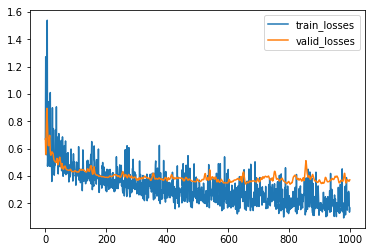

In [59]:
import matplotlib.pyplot as mplot

mplot.plot(train_losses, label='train_losses')
mplot.plot(valid_losses, label='valid_losses')
mplot.legend()
mplot.show()

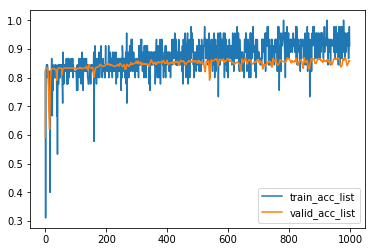

In [60]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc_list, label='train_acc_list')
mplot.plot(valid_acc_list, label='valid_acc_list')
mplot.legend()
mplot.show()